In [9]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from superpoint.settings import DATA_PATH, EXPER_PATH
from superpoint.models.utils import detector_head, box_nms
from superpoint.models.homographies import homography_adaptation
from superpoint.radial_distortion.radial_dist_funct import distort
from superpoint.models.backbones.vgg import vgg_backbone
from superpoint.radial_distortion.radial_dist_funct import distort, undistort
from superpoint.models.magic_point import MagicPoint
from superpoint.models.base_model import BaseModel, Mode
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2
tf.logging.set_verbosity(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def key_point_verification(image, net):

    image_shape = tf.shape(image)[:2]
    H = image_shape[0]
    W = image_shape[1]
    row_c = tf.random.uniform(shape=[], minval=0, maxval=tf.cast(H, tf.float32), dtype=tf.float32)
    col_c = tf.random.uniform(shape=[], minval=0, maxval=tf.cast(W, tf.float32), dtype=tf.float32) 
    lambda_ = tf.constant(0.00001)

    d_image = distort(image,lambda_,(row_c,col_c))
    
    
    u_pred = net(image)
    d_pred = net(d_image)

    u_pred['prob_nms'] = box_nms(tf.reshape(u_pred['prob'], [240,320]), net_config['nms'], keep_top_k=net_config['top_k'])
    u_pred['pred'] = tf.to_int32(tf.greater_equal(u_pred['prob_nms'], net_config['detection_threshold']))

    d_pred['prob_nms'] = box_nms(tf.reshape(d_pred['prob'], [240,320]), net_config['nms'], keep_top_k=net_config['top_k'])
    d_pred['pred'] = tf.to_int32(tf.greater_equal(d_pred['prob_nms'], net_config['detection_threshold']))


    return {'u_pred':u_pred['pred'], 'd_pred':d_pred['pred'],'dist_image': d_image, 'lambda': lambda_, 'center': (row_c, col_c)}


In [11]:
net_config = {
    'data_format': 'channels_last',
    'grid_size': 8,
    'detection_threshold': 0.001,
    'nms': 4,
    'descriptor_size': 256,
    'top_k': 300,
    'batch_size': 32,
    'learning_rate': 0.01,
    'homography_adaptation': {
        'num': 0, 
        'aggregation': 'sum',
        'kernel_reg': 0.,
        'homographies': {
            'translation': True,
            'rotation': True,
            'scaling': True,
            'perspective': True,
            'scaling_amplitude': 0.1,
            'perspective_amplitude_x': 0.22,
            'perspective_amplitude_y': 0.22,
            'translation_overflow': 0.1,
            'allow_artifacts': True
        },
        'filter_counts': 2,
    },
    'training': False,
}

In [12]:
def net(image):
    with tf.variable_scope('magicpoint', reuse=tf.AUTO_REUSE):
        image = tf.reshape(image, [1,240, 320,1])
        features = vgg_backbone(image, **net_config)
        return detector_head(features, **net_config)




def draw_keypoints(img, corners, color, s = 4):
    keypoints = [cv2.KeyPoint(c[1]*s, c[0]*s, 1) for c in np.stack(corners).T]
    img = cv2.resize(img, None, fx=s, fy=s)
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)


In [15]:
image_name = 'COCO_train2014_000000519723.jpg' #'COCO_train2014_000000130745.jpg' #'COCO_train2014_000000000071.jpg' #'COCO_train2014_000000114404.jpg' #'COCO_train2014_000000151493.jpg' #
model_name = 'magic-point_synth'
base_path = Path(DATA_PATH, 'COCO/train2014/')
filename = Path(base_path, image_name)
checkpoint = Path(EXPER_PATH, model_name) 

Tensor("Repeat/Reshape:0", shape=(240, 320), dtype=int32)
Device mapping:



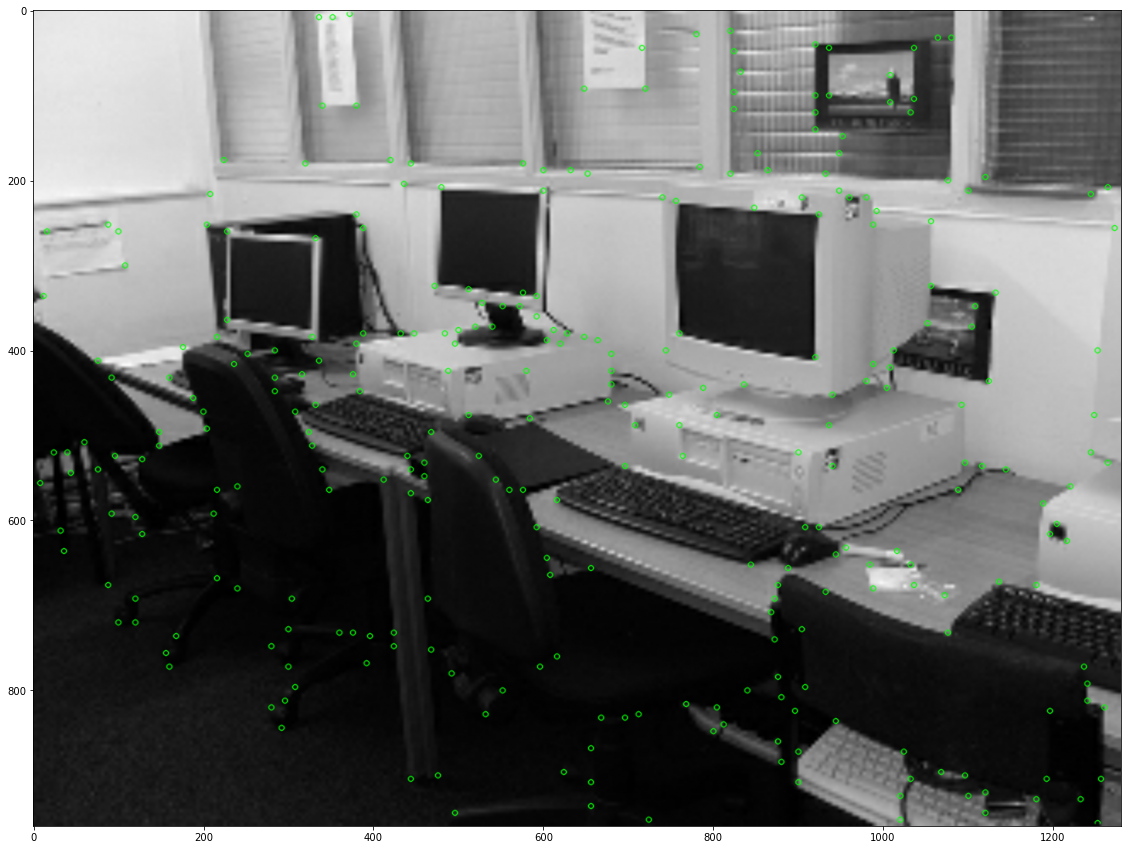

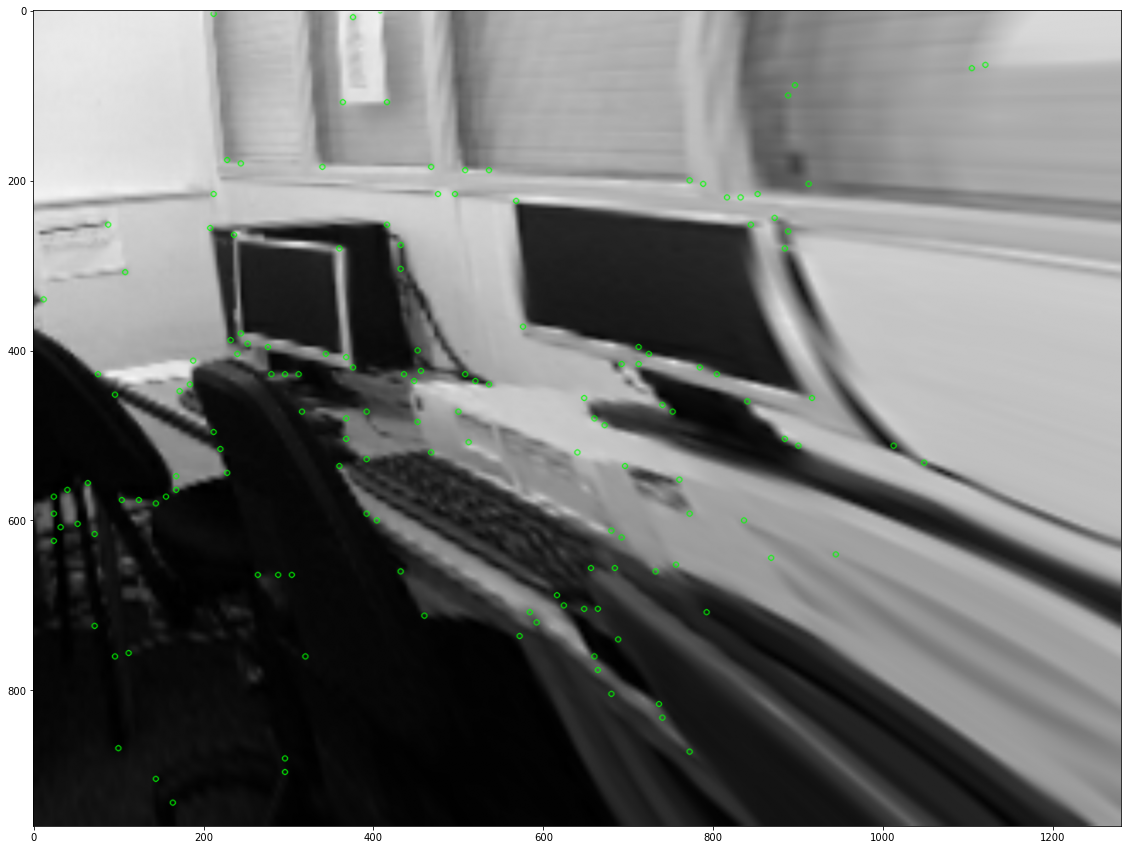

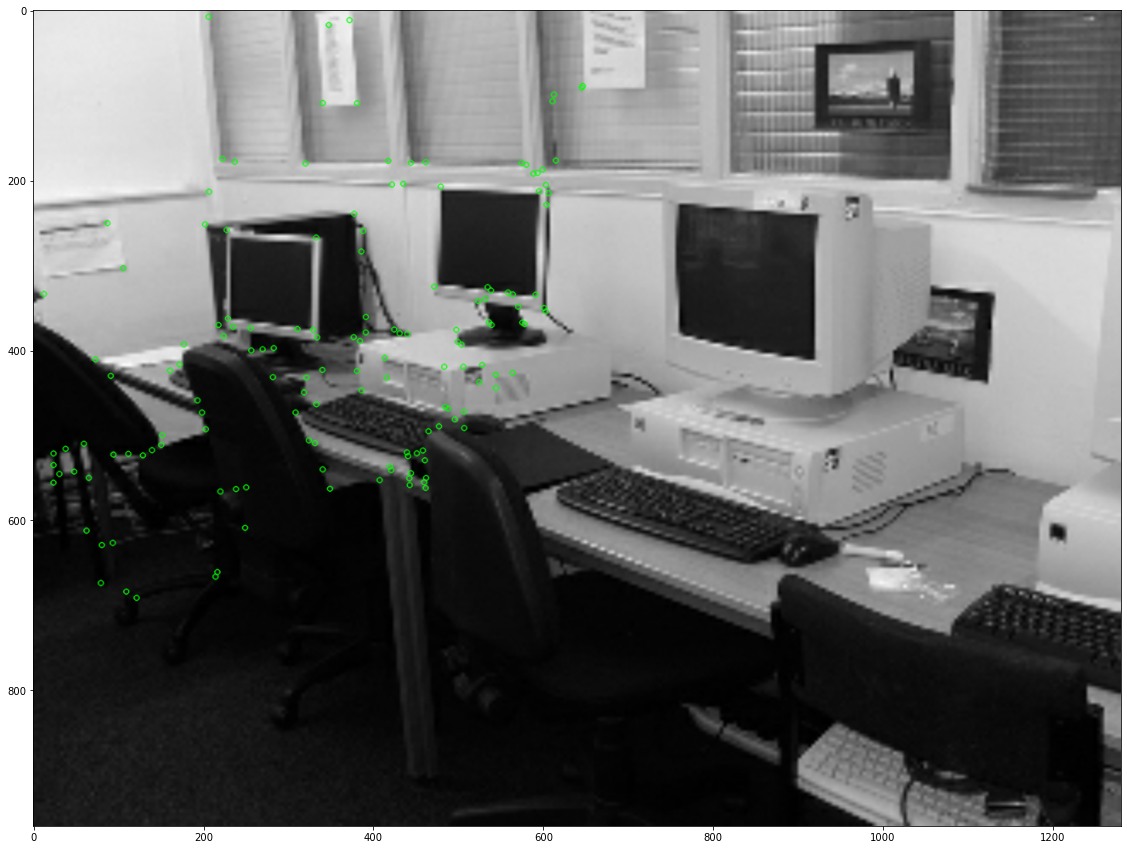

<Figure size 432x288 with 0 Axes>

In [16]:
tf.compat.v1.reset_default_graph(),
image = tf.image.decode_jpeg(tf.read_file(str(filename)), channels=1)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.to_float(tf.image.resize_images(image, [240, 320]))

outputs = key_point_verification(image[...,tf.newaxis], net)

#checkpoint = 'magic-point_synth'

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,  log_device_placement=True)) as sess:

    tf.train.Saver().restore(sess, tf.train.latest_checkpoint(checkpoint));
    im, _out = sess.run([image,outputs])
    
    d_image = _out['dist_image']
    u_pred =  np.reshape(_out['u_pred'], [240, 320])
    d_pred = np.reshape(_out['d_pred'], [240, 320])
    row_c, col_c = _out['center']
    lambda_ = _out['lambda']
    
    arr_col = np.where(d_pred)[0]-[col_c]
    arr_row = np.where(d_pred)[1]-[row_c]
    delta = np.transpose((arr_row,arr_col))
    norms = np.linalg.norm(delta, None,1 ,keepdims=True)**2
    denom = lambda_ * norms + 1
    d_pred_undistorted = np.transpose(delta / denom + [row_c,col_c])
    d_pred_undistorted = [d_pred_undistorted[1],d_pred_undistorted[0]]
    


    im_u = draw_keypoints(im[..., 0]*255, np.where(u_pred), (0, 255, 0))/255.
    im_d = draw_keypoints(d_image*255, np.where(d_pred), (0, 255, 0))/255.
    im_d_undist = draw_keypoints(im[..., 0]*255, d_pred_undistorted, (0, 255, 0))/255.

    #This is the keypoints of the original image
    fig = plt.figure(figsize=(20, 15))
    fig.add_subplot(1,1,1)
    plt.imshow(im_u)

    #This is what superpoint gives for the distorted image
    fig = plt.figure(figsize=(20, 15))
    fig.add_subplot(1,1,1)
    plt.imshow(im_d)
    
    #If superpoint is robust to radial dist, this should give the same result as the first plot
    fig = plt.figure(figsize=(20, 15))
    fig.add_subplot(1,1,1)
    plt.imshow(im_d_undist)

    fig = plt.figure()


    plt.show()
